In [ ]:
#!pip install mmh3

     |████████████████████████████████| 51kB 7.0MB/s 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
import copy
from IPython.display import display
from matplotlib import ticker
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.notebook import tqdm
import os
import torch.utils.data as data
import librosa
import scipy.io.wavfile as wf
import numpy as np
import pandas as pd
from torchvision import transforms
from collections import OrderedDict, defaultdict, Counter
from torch.utils.data.sampler import Sampler
import random
import math
import os
import functools
import time
import os
import glob
import torch
import shutil
import re
import mmh3
from sklearn.metrics import confusion_matrix
import itertools
from google.colab import drive

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/train.7z'
!cp '{zip_path}' .
#!unzip -q train.7z
!7z x train.7z -y > nul
!rm train.7z

Mounted at /content/drive

4/1AY0e-g5GxQCsaDomru-Cb1cVvfe5BEd23pTjAEq7_PIh4lmcKYf1LT7yVFg


In [ ]:
!ls ./train/audio

_background_noise_  dog    four   left	  off	 seven	 three	wow
bed		    down   go	  marvin  on	 sheila  tree	yes
bird		    eight  happy  nine	  one	 six	 two	zero
cat		    five   house  no	  right  stop	 up


# Dataset

## Utils

In [ ]:
# From https://github.com/rwightman/pytorch-commands
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def get_outdir(path, *paths, inc=False):
    outdir = os.path.join(path, *paths)
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    elif inc:
        count = 1
        outdir_inc = outdir + '-' + str(count)
        while os.path.exists(outdir_inc):
            count = count + 1
            outdir_inc = outdir + '-' + str(count)
            assert count < 100
        outdir = outdir_inc
        os.makedirs(outdir)
    return outdir


class CheckpointSaver:
    def __init__(
            self,
            checkpoint_prefix='checkpoint',
            recovery_prefix='recovery',
            checkpoint_dir='',
            recovery_dir='',
            max_history=10):

        self.checkpoint_files = []
        self.best_metric = None
        self.worst_metric = None
        self.max_history = max_history
        assert self.max_history >= 1
        self.curr_recovery_file = ''
        self.last_recovery_file = ''
        self.checkpoint_dir = checkpoint_dir
        self.recovery_dir = recovery_dir
        self.save_prefix = checkpoint_prefix
        self.recovery_prefix = recovery_prefix
        self.extension = '.pth.tar'

    def save_checkpoint(self, state, epoch, metric=None):
        worst_metric = self.checkpoint_files[-1] if self.checkpoint_files else None
        if len(self.checkpoint_files) < self.max_history or metric < worst_metric[1]:
            if len(self.checkpoint_files) >= self.max_history:
                self._cleanup_checkpoints(1)

            filename = '-'.join([self.save_prefix, str(epoch)]) + self.extension
            save_path = os.path.join(self.checkpoint_dir, filename)
            if metric is not None:
                state['metric'] = metric
            torch.save(state, save_path)
            self.checkpoint_files.append((save_path, metric))
            self.checkpoint_files = sorted(self.checkpoint_files, key=lambda x: x[1])

            print("Current checkpoints:")
            for c in self.checkpoint_files:
                print(c)

            if metric is not None and (self.best_metric is None or metric < self.best_metric[1]):
                self.best_metric = (epoch, metric)
                shutil.copyfile(save_path, os.path.join(self.checkpoint_dir, 'model_best' + self.extension))
        return None, None if self.best_metric is None else self.best_metric

    def _cleanup_checkpoints(self, trim=0):
        trim = min(len(self.checkpoint_files), trim)
        delete_index = self.max_history - trim
        if delete_index <= 0 or len(self.checkpoint_files) <= delete_index:
            return
        to_delete = self.checkpoint_files[delete_index:]
        for d in to_delete:
            try:
                print('Cleaning checkpoint: ', d)
                os.remove(d[0])
            except Exception as e:
                print('Exception (%s) while deleting checkpoint' % str(e))
        self.checkpoint_files = self.checkpoint_files[:delete_index]

    def save_recovery(self, state, epoch, batch_idx):
        filename = '-'.join([self.recovery_prefix, str(epoch), str(batch_idx)]) + self.extension
        save_path = os.path.join(self.recovery_dir, filename)
        torch.save(state, save_path)
        if os.path.exists(self.last_recovery_file):
            try:
                print('Cleaning recovery', self.last_recovery_file)
                os.remove(self.last_recovery_file)
            except Exception as e:
                print("Exception (%s) while removing %s" % (str(e), self.last_recovery_file))
        self.last_recovery_file = self.curr_recovery_file
        self.curr_recovery_file = save_path

    def find_recovery(self):
        recovery_path = os.path.join(self.recovery_dir, self.recovery_prefix)
        files = glob.glob(recovery_path + '*' + self.extension)
        files = sorted(files)
        if len(files):
            return files[0]
        else:
            return ''


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

## Dataset class

In [ ]:
# From https://github.com/rwightman/pytorch-commands

AUDIO_EXTENSIONS = ['.wav']

NUM_FOLDS = 10
SILENCE_LABEL = 'silence'
SILENCE_INDEX = 0
UNKNOWN_WORD_LABEL = 'unknown'
UNKNOWN_WORD_INDEX = 1
BACKGROUND_NOISE_DIR_NAME = '_background_noise_'
KNOWN_LABELS = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
UNKNOWN_LABELS = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine',
                  'bird', 'dog', 'cat', 'bed', 'house', 'tree', 'marvin', 'sheila', 'happy', 'wow']


def get_labels(train_unknown=True):
    if train_unknown:
        """
        Train the 'unknown' class by using all training set words
        that aren't in the known set
        """
        foreground_labels = KNOWN_LABELS
        background_labels = [SILENCE_LABEL, UNKNOWN_WORD_LABEL]
    else:
        foreground_labels = KNOWN_LABELS + UNKNOWN_LABELS
        background_labels = [SILENCE_LABEL]
    all_labels = background_labels + foreground_labels
    return all_labels


def find_commands(folder, types=AUDIO_EXTENSIONS):
    commands = []
    background = []
    for root, _, files in os.walk(folder, topdown=False):
        rel_path = os.path.relpath(root, folder) if (root != folder) else ''
        label = os.path.basename(rel_path)
        for f in files:
            base, ext = os.path.splitext(f)
            if ext.lower() in types:
                filename = os.path.join(root, f)
                if label == BACKGROUND_NOISE_DIR_NAME:
                    background.append(filename)
                else:
                    parts = base.split('_nohash_')
                    if len(parts) == 2:
                        speaker_id = parts[0]
                        utter_id = int(parts[1])
                    else:
                        speaker_id = ''
                        utter_id = 0
                    commands.append((speaker_id, utter_id, label, filename))
    return commands, background


def speaker_to_fold(speaker, num_folds=NUM_FOLDS):
    hash = mmh3.hash(speaker, signed=False)
    p = 1 / float(2**32)
    j = 1 / num_folds
    fold = int(hash * p // j)
    return fold


class CommandsDataset(data.Dataset):
    def __init__(
            self,
            root='',
            mode='train',
            fold=0,
            wav_size=16000,
            format='raw',
            train_unknown=True,
            test_aug=0,
            transform=None):

        self.root = root
        self.mode = mode
        self.is_training = self.mode == 'train'
        self.fold = fold
        assert self.fold < NUM_FOLDS
        self.wav_size = wav_size
        self.format = format
        self.train_unknown = train_unknown

        # Training settings, TODO make dict, source from cmd args
        self.silence_prob = 0.11
        self.unknown_prob = 0.11 if train_unknown else 0.0
        self.background_frequency = 0.7
        self.background_volume_range = 0.25
        self.pitch_shift = 0.5
        self.pitch_shift_frequency = 0.0
        self.time_stretch = 0.15
        self.time_stretch_frequency = 0.5
        self.time_shift = 0.22

        # Find dataset input files
        commands, background = find_commands(root)
        print('Found %d command samples and %d background samples.' % (len(commands), len(background)))

        self.targets = []
        self.inputs = []
        self.class_inputs = OrderedDict()
        self.label_to_id = {}
        self.id_to_label = get_labels(train_unknown=train_unknown)
        for i, l in enumerate(self.id_to_label):
            self.label_to_id[l] = i
            self.class_inputs[i] = []
        self.background_data =[]
        if mode == 'test':
            for _, _, _, f in commands:
                self.inputs.append(f)
            self.inputs = np.array(self.inputs)
            self.targets = None
        else:
            self.unknowns = []
            self.num_known = 0
            index = 0
            for s, u, l, f in commands:
                sf = speaker_to_fold(s)
                if mode == 'validate':
                    if sf != fold:
                        continue
                else:
                    if sf == fold:
                        continue
                if l in self.label_to_id:
                    lid = self.label_to_id[l]
                    self.targets.append(lid)
                    self.inputs.append(f)
                    self.class_inputs[lid].append(index)
                    index += 1
                else:
                    self.unknowns.append(f)

            # handle unknown/silence sampling inline so no need for external sampler
            self.num_known = len(self.inputs)
            known_prob = 1.0 - (self.silence_prob + self.unknown_prob)
            dataset_size = int(self.num_known / known_prob)
            if train_unknown:
                unknown_size = int(dataset_size * self.unknown_prob)
            else:
                unknown_size = 0
            silence_size = int(dataset_size * self.silence_prob)
            if silence_size:
                self.inputs += [self.id_to_label[SILENCE_INDEX]] * silence_size
                self.targets += [SILENCE_INDEX] * silence_size
                self.class_inputs[SILENCE_INDEX] += list(range(index, index + silence_size))
                index += silence_size
            if unknown_size:
                if self.is_training:
                    self.inputs += [self.id_to_label[UNKNOWN_WORD_INDEX]] * unknown_size
                else:
                    self.inputs += list(np.random.choice(self.unknowns, unknown_size, replace=False))
                self.targets += [UNKNOWN_WORD_INDEX] * unknown_size
                self.class_inputs[UNKNOWN_WORD_INDEX] += list(range(index, index + unknown_size))
                index += unknown_size
            print(dataset_size, silence_size, unknown_size, known_prob)
            self.inputs = np.array(self.inputs)
            self.targets = np.array(self.targets)

            for b in background:
                wav_audio, wav_rate = librosa.load(b)
                self.background_data.append(wav_audio)

    def _process_sample(
            self,
            filename,
            target,
            pitch_shift=0.,
            pitch_shift_frequency=0.,
            time_stretch=0.,
            time_stretch_frequency=0.,
            time_shift=0.,
            ):
        # Data and labels will be populated and returned.
        desired_samples = 16000
        use_background = self.background_data and self.is_training

        # If we want silence, mute out the main sample but leave the background.
        if target == SILENCE_INDEX:
            foreground_volume = 0.
        else:
            foreground_volume = np.random.uniform(0.8, 1.0) if self.is_training else 1.0

        if self.train_unknown and (
                target == UNKNOWN_WORD_INDEX and filename == UNKNOWN_WORD_LABEL):
            filename = self.unknowns[np.random.randint(len(self.unknowns))]

        sample_rate = 16000
        if foreground_volume > 0:
            sample_rate, sample_audio = wf.read(filename)
            sample_audio = sample_audio.astype(np.float32) / 2**15
            #print(sample_audio.min(), sample_audio.max(), sample_audio.mean())

            if pitch_shift > 0 and np.random.uniform(0, 1) < pitch_shift_frequency:
                pitch_shift_amount = np.random.uniform(-pitch_shift, pitch_shift)
            else:
                pitch_shift_amount = 0
            #print('pitch shift: ', pitch_shift_amount)
            if pitch_shift_amount != 0:
                sample_audio = librosa.effects.pitch_shift(sample_audio, sample_rate, pitch_shift_amount)
                time_stretch_amount = 1.0
            elif time_stretch > 0 and np.random.uniform(0, 1) < time_stretch_frequency:
                time_stretch_amount = np.random.uniform(1.0 - time_stretch, 1.0 + time_stretch)
            else:
                time_stretch_amount = 1.0
            #print('time stretch: ', time_stretch_amount)
            if time_stretch_amount != 1.0:
                sample_audio = librosa.effects.time_stretch(sample_audio, time_stretch_amount)

            actual_samples = sample_audio.shape[0]
            # If we're time shifting, set up the offset for this sample.
            if time_shift > 0:
                time_shift_amount = int(desired_samples * time_shift)
                time_shift_amount = np.random.randint(-time_shift_amount, time_shift_amount)
            else:
                time_shift_amount = 0
            #print('time shift: ', time_shift_amount)
            if time_shift_amount < 0:
                crop_l = -time_shift_amount
                pad_l = 0
            else:
                crop_l = 0
                pad_l = time_shift_amount
            crop_r = min(actual_samples, desired_samples + crop_l - pad_l)
            pad_r = max(0, desired_samples - (crop_r - crop_l + pad_l))
            #print('cl, cr, pl, pr:', crop_l, crop_r, pad_l, pad_r)

            sample_audio = sample_audio[crop_l:crop_r]
            if pad_l and pad_r:
                sample_audio = np.r_[
                    np.random.uniform(-0.001, 0.001, pad_l).astype(np.float32),
                    sample_audio,
                    np.random.uniform(-0.001, 0.001, pad_r).astype(np.float32)]
            elif pad_l:
                sample_audio = np.r_[
                    np.random.uniform(-0.001, 0.001, pad_l).astype(np.float32),
                    sample_audio]
            elif pad_r:
                sample_audio = np.r_[
                    sample_audio,
                    np.random.uniform(-0.001, 0.001, pad_r).astype(np.float32)]
            if foreground_volume != 1.0:
                sample_audio *= foreground_volume
        else:
            sample_audio = np.zeros(desired_samples, dtype=np.float32)

        # Choose a section of background noise to mix in.
        if use_background and np.random.uniform(0, 1) < self.background_frequency:
            background_index = np.random.randint(len(self.background_data))
            background_samples = self.background_data[background_index]
            background_offset = np.random.randint(
                0, len(background_samples) - desired_samples)
            background_cropped = background_samples[
                background_offset:background_offset + desired_samples]
            if target == SILENCE_INDEX:
                background_volume = np.random.uniform(0.01, 0.08)
            else:
                background_volume = np.random.uniform(0.01, self.background_volume_range)
            sample_audio = (sample_audio + background_cropped * background_volume).clip(-1.0, 1.0)

        # lr.output.write_wav('./temp/lr-%d.wav' % i, sample_audio, 16000
        if self.format == 'spectrogram':
            spect = np.abs(librosa.spectrum.stft(
                y=sample_audio, n_fft=512, win_length=480, hop_length=160, center=False))**2
            #print(spect.shape)
            mel = librosa.feature.melspectrogram(S=spect, fmin=125, fmax=7500, n_mels=64)
            #print(mel.shape)
            log_mel = librosa.spectrum.power_to_db(mel)
            mfcc = librosa.feature.mfcc(S=log_mel, n_mfcc=64)
            mfcc_mean = np.mean(mfcc)
            mfcc_std = np.std(mfcc)
            mfcc = (mfcc - mfcc_mean) / (mfcc_std + 1e-6)
            # mfcc = lr.feature.mfcc(
            #     y=sample_audio, sr=sample_rate,
            #     hop_length=192,
            #     n_fft=512,
            #     fmin=125,
            #     fmax=7500,
            #     power=2,
            #     n_mels=128,
            #     n_mfcc=64)
            #print(mfcc.shape)
            #mfcc = (mfcc - self.spect_mean) / self.spect_std
            return mfcc #np.expand_dims(mfcc, axis=0).astype(np.float32)
        else:
            return sample_audio

    def __getitem__(self, index):
        filename = self.inputs[index]
        if self.targets is None:
            target = None
        else:
            target = self.targets[index]

        if self.is_training:
            sample = self._process_sample(
                filename, target,
                pitch_shift=self.pitch_shift,
                pitch_shift_frequency=self.pitch_shift_frequency,
                time_stretch=self.time_stretch,
                time_stretch_frequency=self.time_stretch_frequency,
                time_shift=self.time_shift)
        else:
            sample = self._process_sample(filename, target)

        if target is None:
            target = torch.zeros(1).long()

        sample = torch.tensor(sample.T, dtype=torch.float32)
        return sample, target

    def __len__(self):
        return len(self.inputs)

    def filename(self, index, rel=True):
        abs_filename = self.inputs[index]
        if rel:
            return os.path.relpath(abs_filename, self.root)
        else:
            return abs_filename


class PKSampler(Sampler):

    def __init__(self, dataset, p=8, k=64):
        self.p = p
        self.k = k
        self.dataset = dataset

    def __iter__(self):
        pk_count = len(self) // (self.p * self.k)
        print(pk_count)
        for _ in range(pk_count):
            classes = np.random.choice(
                np.arange(len(self.dataset.class_inputs.keys())), self.p, replace=False)
            for c in classes:
                inputs = self.dataset.class_inputs[c]
                for i in np.random.permutation(len(inputs))[:self.k]:
                    yield inputs[i]

    def __len__(self):
        pk = self.p * self.k
        return ((len(self.dataset) - 1) // pk + 1) * pk

# Test if it works
# def _test():
#     ds = CommandsDataset(
#         root='/content/drive/MyDrive/train/audio')
#     print(ds.inputs)


# if __name__ == '__main__':
#     _test()

# Functions

In [ ]:
# Create optimizer excluding frozen layers
def create_optimizer(model_ft, opt_type, feature_extract=False, lr=0.001,
                     momentum=0.99, weight_decay=0, betas=(0.9, 0.999)):
    optimizer_ft = None
    params_to_update = model_ft.parameters()
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)

    if opt_type == 'SGD':
        optimizer_ft = optim.SGD(params_to_update, lr=lr,
                            weight_decay=weight_decay)
        

    elif opt_type == 'Momentum':
        optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=momentum,
                            weight_decay=weight_decay)
        
    
    elif opt_type == 'Nesterov':
        optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=momentum,
                            weight_decay=weight_decay, nesterov=True)
        
        
    elif opt_type == 'Adam':
        optimizer_ft = optim.Adam(params_to_update, lr=lr,
                                  betas=betas, eps=1e-08,
                                  weight_decay=weight_decay)
        
    else:
        print("Invalid optimizer name, exiting...")
        exit()

    print()
    print('-' * 10)
    print(opt_type)
    print('-' * 10)
    return optimizer_ft


# Prepare model before training
def prepare_model(model_name, device, opt_type, **kwargs):
    
    if model_name == "LSTM":
        input_size = 64 # == n_mfcc
        hidden_size = 64
        num_layers = 3
        num_classes = 12
        classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on',
                   'off', 'stop', 'go', 'silence', 'unknown']
        device = device
        model = RNN(input_size, hidden_size, num_layers, num_classes, device,
                    classes)
        
    model = model.to(device)
    optimizer = create_optimizer(model, opt_type, **kwargs)
    criterion = nn.CrossEntropyLoss()
    print('-' * 10)
    print(model_name)
    print('-' * 10)
    print()

    return model, criterion, optimizer



# From https://stackoverflow.com/questions/62265351/measuring-f1-score-
# for-multiclass-classification-natively-in-pytorch
class F1Score:
    """
    Class for f1 calculation in Pytorch.
    """

    def __init__(self, average: str = 'weighted'):
        """
        Init.

        Args:
            average: averaging method
        """
        self.average = average
        if average not in [None, 'micro', 'macro', 'weighted']:
            raise ValueError('Wrong value of average parameter')

    @staticmethod
    def calc_f1_micro(predictions: torch.Tensor, labels: torch.Tensor):
        """
        Calculate f1 micro.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """
        true_positive = torch.eq(labels, predictions).sum().float()
        f1_score = torch.div(true_positive, len(labels))
        return f1_score

    @staticmethod
    def calc_f1_count_for_label(predictions: torch.Tensor,
                                labels: torch.Tensor, label_id: int):
        """
        Calculate f1 and true count for the label

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels
            label_id: id of current label

        Returns:
            f1 score and true count for label
        """
        # label count
        true_count = torch.eq(labels, label_id).sum()

        # true positives: labels equal to prediction and to label_id
        true_positive = torch.logical_and(torch.eq(labels, predictions),
                                          torch.eq(labels,
                                                   label_id)).sum().float()
        # precision for label
        precision = torch.div(true_positive,
                              torch.eq(predictions, label_id).sum().float())
        # replace nan values with 0
        precision = torch.where(torch.isnan(precision),
                                torch.zeros_like(precision).type_as(
                                    true_positive),
                                precision)

        # recall for label
        recall = torch.div(true_positive, true_count)
        # f1
        f1 = 2 * precision * recall / (precision + recall)
        # replace nan values with 0
        f1 = torch.where(torch.isnan(f1),
                         torch.zeros_like(f1).type_as(true_positive), f1)
        return f1, true_count

    def __call__(self, predictions: torch.Tensor, labels: torch.Tensor):
        """
        Calculate f1 score based on averaging method defined in init.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """

        # simpler calculation for micro
        if self.average == 'micro':
            return self.calc_f1_micro(predictions, labels)

        f1_score = 0
        for label_id in range(1, len(labels.unique()) + 1):
            f1, true_count = self.calc_f1_count_for_label(predictions,
                                                          labels, label_id)

            if self.average == 'weighted':
                f1_score += f1 * true_count
            elif self.average == 'macro':
                f1_score += f1

        if self.average == 'weighted':
            f1_score = torch.div(f1_score, len(labels))
        elif self.average == 'macro':
            f1_score = torch.div(f1_score, len(labels.unique()))

        return f1_score



# Based on modified https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given
     patience.
    """
    def __init__(self, patience=3, delta=0.04):
        """
        Args:
            patience (int): How long to wait after last time validation loss
                            improved.
                            Default: 3
            delta (float): Minimum change in the monitored quantity to qualify
                           as an improvement.
                            Default: 0.04           
        """
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
    def __call__(self, val_loss):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0  



# Function for training model from scrath, finetuning and feature extraction
def train_model(model, criterion, optimizer, num_epochs, dataloaders, patience,
                delta, sched=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    val_f1_history = []
    val_auc_history = []

    train_acc_history = []
    train_loss_history = []
    train_f1_history = []
    train_auc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    f1_metric = F1Score('macro')
    # Scheduler for optimizing learning rate
    if sched:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                           T_max=num_epochs)
        
    # Initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, delta=delta)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_f1 = 0.0
            #running_auc = 0.0

            # Iterate over data
            for i, data in enumerate(dataloaders[phase], 1):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)


                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if sched:
                            scheduler.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_f1 += f1_metric(preds, labels.data) * inputs.size(0)
                #running_auc += roc_auc_compute_fn(outputs, labels.data)


            # print loss and acc each epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() \
             / len(dataloaders[phase].dataset)
            epoch_f1 = running_f1 / len(dataloaders[phase].dataset)
            #epoch_auc = running_auc / len(dataloaders[phase].dataset)
            print()
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,
                                                       epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                time_to_best_acc = time.time() - since
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                val_f1_history.append(epoch_f1)
                #val_auc_history.append(epoch_auc)
                # early stopping based on loss
                early_stopping(epoch_loss)
            elif phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
                train_f1_history.append(epoch_f1)
                #train_auc_history.append(epoch_auc)

        # early stopping
        if early_stopping.early_stop:
            print()
            print("@@@@ Early stopping @@@@")
            print()
            break
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed //
                                                        60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # create dicts with scores
    val_dict = {"acc": val_acc_history, "loss": val_loss_history,
                "f1": val_f1_history, "auc": val_auc_history}

    train_dict = {"acc": train_acc_history, "loss": train_loss_history,
                "f1": train_f1_history, "auc": train_auc_history}

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_dict, train_dict, time_to_best_acc



# Plot history of fitting
def plot_hist(hists, names, model_name, phase, metric, num_epochs):
    
    if torch.is_tensor(hists[0][0]):
        hists = [[h.cpu().numpy() for h in hist] for hist in hists]
    plt.title(f"Training process on {phase} dataset")
    plt.xlabel("Training epochs")
    plt.ylabel(f"Value of {metric}")
    for hist, name in zip(hists, names):
        plt.plot(range(1,len(hist)+1),hist,label=name)

    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter(
                "{x:.3f}"))
    plt.show()



# Plot multiple plots
def plot_hists(hists_dictionary, methods, model_name, phases, num_epochs,
               metrics, size=(8,8)):
    for metric in metrics:
        print()
        print(metric)
        print()
        for i, phase in enumerate(phases):
            hist = hists_dictionary[phase]
            metric_values = [h[metric] for h in hist]
            plt.subplots(figsize=size)
            plt.subplot(211 + i)
            plot_hist(metric_values, methods, model_name, phase, metric,
                      num_epochs)
            


# Plot hitory of fitting for one model
def plot_one_model(hists_dictionary, num_epochs, metrics, model_name):
    hists_train = hists_dictionary['train']
    hists_val = hists_dictionary['val']
    for metric in metrics:
        print()
        print(metric)
        print()
        htm = hists_train[0][metric]
        hvm = hists_val[0][metric]
        if torch.is_tensor(htm[0]):
            htm = [h.cpu().numpy() for h in htm]
            hvm = [h.cpu().numpy() for h in hvm]
        hists = [htm, hvm]
        phases = ['train', 'val']
        plt.title(f"Training process for {model_name}")
        plt.xlabel("Training epochs")
        plt.ylabel(f"Value of {metric}")
        for hist, name in zip(hists, phases):
            plt.plot(range(1,len(hist)+1),hist,label=name)

        plt.xticks(np.arange(1, num_epochs+1, 1.0))
        plt.legend()
        plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter(
                    "{x:.3f}"))
        plt.show()





# Tables of results
def table_results(val_dicts, train_dicts, times, names, metrics, model_name, 
                  lrs):

    rows = {}
    colnames = ['time_to_best_acc', 'lr']
    for i, name in enumerate(names):
        rows[name] = [times[i], lrs[i]]
        val_dict = val_dicts[i]
        train_dict = train_dicts[i]
        
        for metric in metrics:
            hist_val = val_dict[metric]
            hist_train = train_dict[metric]

            if torch.is_tensor(hist_val[0]):
                hist_val = [hist.cpu().numpy() for hist in hist_val]
                hist_train = [hist.cpu().numpy() for hist in hist_train]

            if metric == 'loss':
                best_val = np.min(hist_val)
                best_train = np.min(hist_train)
            else:
                best_val = np.max(hist_val)
                best_train = np.max(hist_train)

            rows[name].append(best_val)
            rows[name].append(best_train)
            
    for metric in metrics:
        colnames.append(f"best_train_{metric}")
        colnames.append(f"best_val_{metric}")
           
    table = pd.DataFrame.from_dict(rows, orient='index',
                       columns=colnames)
    #table = table.style.set_caption(f"Training results for {model_name}")
    return table



# Show classes accuracy
def classes_acc(classes, model):
    class_correct = list(0. for i in range(12))
    class_total = list(0. for i in range(12))
    with torch.no_grad():
        for data in loader_eval:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(12):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))



#source:
# https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')




def plot_cm(classes_list, model, dataloaders_dict):
    nb_classes = len(classes_list)
    cm = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    cm[t.long(), p.long()] += 1
    cm_int = cm.numpy().astype("int")
    plt.figure(figsize=(12,12))
    plot_confusion_matrix(cm_int, classes_list)

# Experiments

## *LSTM*

### Dataset

In [ ]:
 # Parameters
 train_input_root = './train/audio'
 fold = 9
 wav_size = (16000,)
 batch_size = 64
 workers = 2
 out_format = 'spectrogram' # or 'waveform

dataset_train = CommandsDataset(
        root=train_input_root,
        mode='train',
        fold=fold,
        wav_size=wav_size,
        format=out_format,
    )

loader_train = data.DataLoader(
        dataset_train,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=True,
        num_workers=workers
    )

dataset_eval = CommandsDataset(
        root=train_input_root,
        mode='validate',
        fold=fold,
        wav_size=wav_size,
        format=out_format,
    )

loader_eval = data.DataLoader(
        dataset_eval,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=False,
        num_workers=workers
    )

dataloaders_dict = {'train':loader_train, 'val':loader_eval}


# Checking the train dataset
for wave, labels in loader_train:  
    print('Image batch dimensions:', wave.shape)
    print('Image label dimensions:', labels.shape)
    break

# Checking the valid dataset
for wave, labels in loader_eval:  
    print('Image batch dimensions:', wave.shape)
    print('Image label dimensions:', labels.shape)
    break

Found 64721 command samples and 6 background samples.
27455 3020 3020 0.78
Found 64721 command samples and 6 background samples.
2906 319 319 0.78
Image batch dimensions: torch.Size([64, 97, 64])
Image label dimensions: torch.Size([64])
Image batch dimensions: torch.Size([64, 97, 64])
Image label dimensions: torch.Size([64])


### Architecture

In [ ]:
# Recurrent neural network (many-to-one)
# From https://github.com/felixchenfy/Speech-Commands-Classification-by-LSTM-PyTorch
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, device, classes=None):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.device = device
        self.classes = classes

    def forward(self, x):
        # Set initial hidden and cell states
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device) 
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device) 
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # shape = (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

    def predict(self, x):
        '''Predict one label from one sample's features'''
        # x: feature from a sample, LxN
        #   L is length of sequency
        #   N is feature dimension
        x = torch.tensor(x[np.newaxis, :], dtype=torch.float32)
        x = x.to(self.device)
        outputs = self.forward(x)
        _, predicted = torch.max(outputs.data, 1)
        predicted_index = predicted.item()
        return predicted_index
    
    def set_classes(self, classes):
        self.classes = classes 
    
    def predict_audio_label(self, audio):
        idx = self.predict_audio_label_index(audio)
        assert self.classes, "Classes names are not set. Don't know what audio label is"
        label = self.classes[idx]
        return label

    def predict_audio_label_index(self, audio):
        audio.compute_mfcc()
        x = audio.mfcc.T # (time_len, feature_dimension)
        idx = self.predict(x)
        return idx

### Training

In [ ]:
# learning parameters
num_epochs = 10
lr = 0.0001

# methodology parameters
method = 'Adam'
phases = ['train', 'val']
metrics = ['acc', 'loss', 'f1'] #'auc'

# early stopping parameters
patience = 4
delta = 0.01

# display parameters
pd.options.display.float_format = "{:,.4f}".format
classes = ['silence', 'unknown', 'yes', 'no', 'up', 'down', 'left', 'right',
           'on', 'off', 'stop', 'go']

In [ ]:
model_name = 'LSTM'
hists_lstm = {'train': [], 'val': []}
times_lstm = []
best_lrs_lstm = []

net = prepare_model(model_name, device, method, lr=lr)
model_lstm, v_dict, t_dict, time_i = train_model(*net,
                                        num_epochs=num_epochs,
                                        dataloaders=dataloaders_dict,
                                        patience=patience, delta=delta)

hists_lstm['train'].append(t_dict)
hists_lstm['val'].append(v_dict)
times_lstm.append(time_i)
best_lrs_lstm.append(lr)


----------
Adam
----------
----------
LSTM
----------

Epoch 1/10
----------

train Loss: 2.4227 Acc: 0.1372

val Loss: 2.1893 Acc: 0.2072

Epoch 2/10
----------

train Loss: 2.1821 Acc: 0.2251

val Loss: 1.9724 Acc: 0.2971

Epoch 3/10
----------

train Loss: 2.0310 Acc: 0.2762

val Loss: 1.8542 Acc: 0.3470

Epoch 4/10
----------

train Loss: 1.9454 Acc: 0.3118

val Loss: 1.7798 Acc: 0.3838

Epoch 5/10
----------

train Loss: 1.9190 Acc: 0.3247

val Loss: 2.1357 Acc: 0.2396

Epoch 6/10
----------

train Loss: 2.0078 Acc: 0.2730

val Loss: 1.7959 Acc: 0.3570

Epoch 7/10
----------

train Loss: 1.8974 Acc: 0.3234

val Loss: 1.7321 Acc: 0.3900

Epoch 8/10
----------

train Loss: 1.8400 Acc: 0.3517

val Loss: 1.6731 Acc: 0.4155

Epoch 9/10
----------

train Loss: 1.7910 Acc: 0.3670

val Loss: 1.6312 Acc: 0.4293

Epoch 10/10
----------

train Loss: 1.7393 Acc: 0.3868

val Loss: 1.5859 Acc: 0.4427

Training complete in 48m 42s
Best val Acc: 0.442685


#### Training process


acc



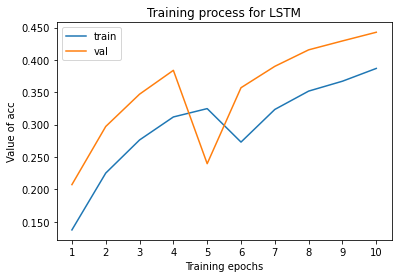


loss



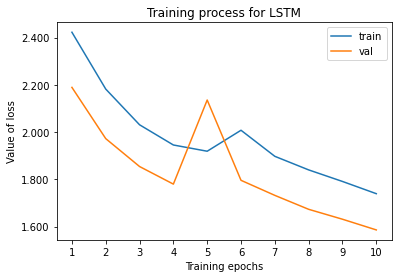


f1



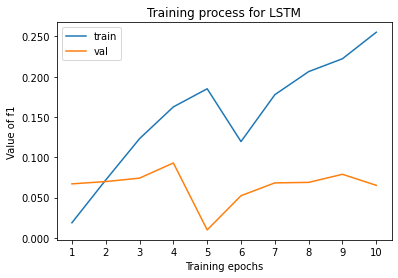

In [ ]:
plot_one_model(hists_lstm, num_epochs, metrics, model_name)

Better results on validation set are probably due to augmentation. F1 score and acc are the same, probably becouse of balanced classes. We can change method of averaging f1 for multiple classes. In classification tasks for which every test case is guaranteed to be assigned to exactly one class, micro-F is equivalent to accuracy. We can use macro, I have already change it in code.

#### Results

In [ ]:
table_lstm = table_results(hists_lstm['train'], hists_lstm['val'],
                           times_lstm, [model_name], metrics,
                           model_name, best_lrs_lstm)
display(table_lstm)

,time_to_best_acc,lr,best_train_acc,best_val_acc,best_train_loss,best_val_loss,best_train_f1,best_val_f1
LSTM,"2,921.8959",0.0001,0.3868,0.4427,1.7393,1.5859,0.2553,0.0930


#### Classes accuracy

In [ ]:
classes_acc(classes, model_lstm)

Accuracy of silence : 100 %
Accuracy of unknown : 35 %
Accuracy of   yes : 75 %
Accuracy of    no :  6 %
Accuracy of    up : 37 %
Accuracy of  down :  8 %
Accuracy of  left : 43 %
Accuracy of right : 81 %
Accuracy of    on : 25 %
Accuracy of   off : 33 %
Accuracy of  stop : 31 %
Accuracy of    go : 25 %


#### Confussion matrix

Confusion matrix, without normalization


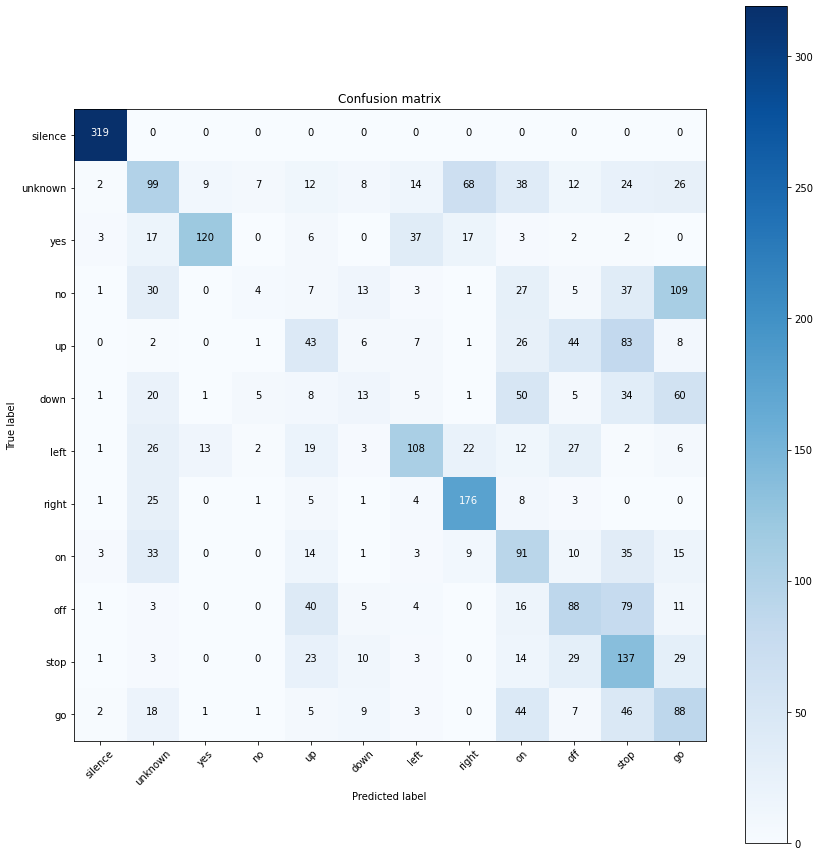

In [ ]:
plot_cm(classes, model_lstm, dataloaders_dict)

Silence is classified with realy good accuracy, but unknown class is pretty big problem.

##*Simple RNN*

### Data

In [ ]:
# Parameters
train_input_root = './train/audio'
fold = 0
wav_size = (16000,)
batch_size = 64
workers = 2
out_format = 'waveform' # or 'spectrogram'

dataset_train = CommandsDataset(
        root=train_input_root,
        mode='train',
        fold=fold,
        wav_size=wav_size,
        format=out_format,
    )

loader_train = data.DataLoader(
        dataset_train,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=True,
        num_workers=workers
    )

dataset_eval = CommandsDataset(
        root=train_input_root,
        mode='validate',
        fold=fold,
        wav_size=wav_size,
        format=out_format,
    )

loader_eval = data.DataLoader(
        dataset_eval,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=False,
        num_workers=workers
    )

dataloaders_dict = {'train':loader_train, 'val':loader_eval}


# Checking the train dataset
for wave, labels in loader_train:  
    print('Image batch dimensions:', wave.shape)
    print('Image label dimensions:', labels.shape)
    break

# Checking the valid dataset
for wave, labels in loader_eval:  
    print('Image batch dimensions:', wave.shape)
    print('Image label dimensions:', labels.shape)
    break

Found 64721 command samples and 6 background samples.
27525 3027 3027 0.78
Found 64721 command samples and 6 background samples.
2835 311 311 0.78
Image batch dimensions: torch.Size([6400, 16000])
Image label dimensions: torch.Size([6400])
Image batch dimensions: torch.Size([2834, 16000])
Image label dimensions: torch.Size([2834])


### Architecture

In [ ]:
wave.shape

torch.Size([64, 97, 64])

### Training